# Mapping digit-representations in the human primary somatosensory cortex and their layer-dependent functional connectivity at 7T.
## Analysis

In this notebook, we are describing and, where possible, performing the analysis of this publication.

In [235]:
# basic
import glob
import itertools
import pandas as pd
import numpy as np
import os

# plotting
from nilearn import plotting
from scipy import ndimage
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

# neuroimaging
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from nibabel import load, save, Nifti1Image
import nipype.interfaces.fsl as fsl
import nilearn
import ants

# misc
from scipy.ndimage import morphology
from scipy import stats
from scipy import interpolate


%matplotlib inline

### Event-files

Let's start by generating the event-files for the stimulation runs. Because the same stimulation patterns were used for all runs, we can do this once for all subjects. However, we have to take care of the number of runs that individual participants have.

In [87]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'

subFolders = sorted(glob.glob(root + '/sub*'))
subs = [path.split('/')[-1] for path in subFolders]

In [88]:
subs

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

In [5]:
folder = '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/log-files'

for pattern in ['A','B']:
    file = glob.glob(f'{folder}/sub14_run*-mPTS_2x3ch_2019_SlowBlock_8TRs_t3_1{pattern}.log')

    f = open(file[0])

    df = pd.read_csv(f, skiprows=2, sep='\t', lineterminator='\n',
                         usecols=["Code", 'Time'])
    df.rename(columns={'Time': 'start_time','Code':'Type'}, inplace=True)
    
    df["start_time"] = pd.to_numeric(df["start_time"])

    first_pulse_time = df.at[1,'start_time']
    last_pulse_time = int(df.at[df.last_valid_index(),'start_time'])
    
    
    df['start_time'] = df['start_time'].sub(first_pulse_time) # normalize to first pulse-time
    df['start_time'] = df['start_time'].div(10000) # convert to seconds
    

    eventTypes = ['D2', 'D3', 'D4', 'Baseline']

    df = df.loc[df['Type'].str.contains('|'.join(eventTypes))]
    df.reset_index(drop = True, inplace=True)


    durations = [abs(df['start_time'][i]-df['start_time'][i+1]) for i in range(len(df['start_time'])-1)]
    durations.append(abs(df['start_time'].iloc[-1]-(last_pulse_time-first_pulse_time)/10000))

    df['duration'] = durations
    df['factor'] = np.ones(len(df['start_time']))

    
    for eventType in eventTypes:
        tmp = df.loc[df['Type'].str.contains(eventType)].drop(columns = ['Type']).astype(int)
        tmp.to_csv(f'{root}/derivatives/designFiles/stimulationPatterns/pattern{pattern}_{eventType}.txt', sep=' ', index=False, header=False)



In [49]:
folder = f'{root}/derivatives/logFiles'

logFiles = sorted(glob.glob(f'{folder}/*.log'))


for file in logFiles:
    fileName = file.split("/")[-1]
    subNumber = fileName[3:5]
    runNumber = fileName[9]
    
    if not subNumber.isnumeric():
        continue
    os.system(f'mkdir {root}/derivatives/designFiles/stimulationPatterns/sub-{subNumber}')
    f = open(file)

    df = pd.read_csv(f, skiprows=2, sep='\t', lineterminator='\n',
                         usecols=["Code", 'Time'])
    df.rename(columns={'Time': 'start_time','Code':'Type'}, inplace=True)
    
    df["start_time"] = pd.to_numeric(df["start_time"])

    first_pulse_time = df.at[1,'start_time']
    last_pulse_time = int(df.at[df.last_valid_index(),'start_time'])
    
    
    df['start_time'] = df['start_time'].sub(first_pulse_time) # normalize to first pulse-time
    df['start_time'] = df['start_time'].div(10000) # convert to seconds
    

    eventTypes = ['D1', 'D2', 'D3', 'D4', 'D5', 'Baseline']

    df = df.loc[df['Type'].str.contains('|'.join(eventTypes))]
    df.reset_index(drop = True, inplace=True)


    durations = [abs(df['start_time'][i]-df['start_time'][i+1]) for i in range(len(df['start_time'])-1)]
    durations.append(abs(df['start_time'].iloc[-1]-(last_pulse_time-first_pulse_time)/10000))

    df['duration'] = durations
    df['factor'] = np.ones(len(df['start_time']))

    
    for eventType in eventTypes:
        tmp = df.loc[df['Type'].str.contains(eventType)].drop(columns = ['Type']).astype(int)
        if not tmp.empty:
            tmp.to_csv(f'{root}/derivatives/designFiles/stimulationPatterns/sub-{subNumber}/sub-{subNumber}_ses-001_task-stim_run-00{runNumber}_{eventType}.txt', sep=' ', index=False, header=False)



## Prepare GLM

To automate the GLM, we prepared a template .fsf file and will loop through all participants to create their own. 

**take care**

In sub-12,  we stimulated all 5 fingers. Therefore, this subject has to handled differently and we created the .fsf files manually.

In [50]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
            
            eventFile = f'{root}/{sub}/ses-001/events/{base}.txt'
            
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            print(nrVolumes)
#             if int(base[-1])%2 != 0:
#                 pattern = 'patternA'            
#             if int(base[-1])%2 == 0:
#                 pattern = 'patternB'
            
#             replacements = {'STIMPATTERN': pattern,'SUBJECT': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}
            replacements = {'SUBJECT': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}



            with open(f"{fsfDir}/stimulationDesignTemplate{modality}.fsf") as infile:
                with open(f"{fsfDir}/{base}_{modality}.fsf", 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

BOLD
sub-02_ses-003_task-stim_run-001
406
sub-02_ses-003_task-stim_run-002
404
VASO
sub-02_ses-003_task-stim_run-001
404
sub-02_ses-003_task-stim_run-002
402
BOLD
sub-05_ses-002_task-stim_run-001
402
VASO
sub-05_ses-002_task-stim_run-001
400
BOLD
sub-06_ses-001_task-stim_run-001
400
VASO
sub-06_ses-001_task-stim_run-001
398
BOLD
sub-07_ses-001_task-stim_run-001
402
sub-07_ses-001_task-stim_run-002
402
VASO
sub-07_ses-001_task-stim_run-001
400
sub-07_ses-001_task-stim_run-002
400
BOLD
sub-09_ses-001_task-stim_run-001
402
VASO
sub-09_ses-001_task-stim_run-001
400
BOLD
sub-10_ses-001_task-stim_run-001
402
VASO
sub-10_ses-001_task-stim_run-001
400
BOLD
sub-12_ses-001_task-stim_run-001
328
sub-12_ses-001_task-stim_run-002
344
sub-12_ses-001_task-stim_run-003
342
sub-12_ses-001_task-stim_run-004
350
VASO
sub-12_ses-001_task-stim_run-001
326
sub-12_ses-001_task-stim_run-002
342
sub-12_ses-001_task-stim_run-003
340
sub-12_ses-001_task-stim_run-004
350
BOLD
sub-15_ses-001_task-stim_run-001
402


### Run first level GLM

In [51]:
import glob
import os


fsfDir = f"{root}/derivatives/designFiles/fsfs"


feats = sorted(glob.glob(f'{fsfDir}/*.fsf'))

# for feat1, feat2 in zip(feats[8::2],feats[9::2]):
#     print(f'1: {feat1}')
#     print(f'2: {feat2}')
#     os.system(f'feat {feat1} & feat {feat2}')

In [106]:
for sub in ['sub-02', 'sub-12']:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*.fsf'))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
        print(f'1: {feat1}')
        print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-002_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-002_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-002_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/su

### Prepare second level GLMs

In [111]:
subs[6:7]

['sub-12']

In [117]:
for sub in subs[6:7]:
    feats = sorted(glob.glob(f'{root}/derivatives/{sub}/func/*.feat'))

In [118]:
feats

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-001_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-001_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-002_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-002_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-003_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-003_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-004_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-

In [119]:
%%bash -s "{" ".join(feats)}" 

for folder in $1
do

cd $folder
mkdir reg
cp $FSLDIR/etc/flirtsch/ident.mat reg/example_func2standard.mat
cp mean_func.nii.gz reg/standard.nii.gz

done

mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists


['sub-18']

## Define ROIs

### Upsample statistical maps

In [126]:
subs

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

In [129]:
for sub in subs[:1]:
    print(sub)
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))
    
    if len(runs) == 1:

        base = os.path.basename(run[0]).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz')     

    if len(runs) > 1:
        
        for modality in modalities:

            for copeNr in range(1,7):
                
                os.system(f'c3d {root}/derivatives/{sub}/func/{sub}_ses-003_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{sub}_ses-003_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')     

sub-02


In [140]:
modalities = ['BOLD', 'VASO']

for sub in subs:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            print(modality)
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz')     

sub-02_ses-003_task-stim_run-001
BOLD
VASO
sub-02_ses-003_task-stim_run-002
BOLD
VASO
sub-05_ses-002_task-stim_run-001
BOLD
VASO
sub-06_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-002
BOLD
VASO
sub-09_ses-001_task-stim_run-001
BOLD
VASO
sub-10_ses-001_task-stim_run-001
BOLD
VASO
sub-12_ses-001_task-stim_run-001
BOLD
VASO
sub-12_ses-001_task-stim_run-002
BOLD
VASO
sub-12_ses-001_task-stim_run-003
BOLD
VASO
sub-12_ses-001_task-stim_run-004
BOLD
VASO
sub-15_ses-001_task-stim_run-001
BOLD
VASO
sub-15_ses-001_task-stim_run-002
BOLD
VASO
sub-15_ses-001_task-stim_run-003
BOLD
VASO
sub-16_ses-001_task-stim_run-001
BOLD
VASO
sub-16_ses-001_task-stim_run-002
BOLD
VASO
sub-16_ses-001_task-stim_run-003
BOLD
VASO
sub-17_ses-001_task-stim_run-001
BOLD
VASO
sub-17_ses-001_task-stim_run-002
BOLD
VASO
sub-17_ses-001_task-stim_run-003
BOLD
VASO
sub-18_ses-001_task-stim_run-001
BOLD
VASO
sub-18_ses-001_task-stim_run-002
BOLD
VASO
sub-18_ses-

In [105]:
modalities = ['BOLD', 'VASO']

for sub in ['sub-07']:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            print(modality)
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{sub}_ses-001_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{sub}_ses-001_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')     

sub-07_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-002
BOLD
VASO


Because not all subjects show reliable peaks in the VASO data, we selected the ROIs based on the BOLD activity. Here, we find the slice with highest zscores. In BOLD and VASO

In [131]:
runs

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-05/ses-002/func/sub-05_ses-002_task-stim_run-001_cbv.nii.gz']

In [132]:
base

''

In [134]:
for sub in subs:
    print(sub)
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))
    
    if len(runs) == 1:

        base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:

            for roi,copeNr in zip(digits, range(1,4)):
                zMap = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz').get_fdata()
                maxVal = 0
                MaxSlice = 0
                for sliceNr in range(0,zMap.shape[-1]):
                    if np.amax(zMap[:,:,sliceNr]) > maxVal:
                        maxVal = np.amax(zMap[:,:,sliceNr])
                        MaxSlice = sliceNr
                print(f'{roi} {modality} {MaxSlice}')

    if len(runs) > 1:
        
        for modality in modalities:

            for roi,copeNr in zip(digits, range(1,4)):
                zMapFile = glob.glob(f'{root}/derivatives/{sub}/func/{sub}_ses-00*_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')[0]
                
                zMap = nb.load(zMapFile).get_fdata()
                maxVal = 0
                MaxSlice = 0
                for sliceNr in range(0,zMap.shape[-1]):
                    if np.amax(zMap[:,:,sliceNr]) > maxVal:
                        maxVal = np.amax(zMap[:,:,sliceNr])
                        MaxSlice = sliceNr
                print(f'{roi} {modality} {MaxSlice}')

sub-02
D2 BOLD 12
D3 BOLD 14
D4 BOLD 13
D2 VASO 12
D3 VASO 12
D4 VASO 11
sub-05
sub-05_ses-002_task-stim_run-001
D2 BOLD 11
D3 BOLD 12
D4 BOLD 18
D2 VASO 17
D3 VASO 8
D4 VASO 15
sub-06
sub-06_ses-001_task-stim_run-001
D2 BOLD 9
D3 BOLD 12
D4 BOLD 13
D2 VASO 18
D3 VASO 20
D4 VASO 14
sub-07
D2 BOLD 12
D3 BOLD 10
D4 BOLD 19
D2 VASO 18
D3 VASO 10
D4 VASO 17
sub-09
sub-09_ses-001_task-stim_run-001
D2 BOLD 10
D3 BOLD 11
D4 BOLD 12
D2 VASO 13
D3 VASO 7
D4 VASO 19
sub-10
sub-10_ses-001_task-stim_run-001
D2 BOLD 13
D3 BOLD 15
D4 BOLD 19
D2 VASO 3
D3 VASO 3
D4 VASO 17
sub-12
D2 BOLD 9
D3 BOLD 14
D4 BOLD 13
D2 VASO 9
D3 VASO 14
D4 VASO 14
sub-15
D2 BOLD 12
D3 BOLD 13
D4 BOLD 19
D2 VASO 12
D3 VASO 20
D4 VASO 13
sub-16
D2 BOLD 15
D3 BOLD 18
D4 BOLD 17
D2 VASO 15
D3 VASO 15
D4 VASO 4
sub-17
D2 BOLD 10
D3 BOLD 9
D4 BOLD 13
D2 VASO 2
D3 VASO 11
D4 VASO 10
sub-18
D2 BOLD 11
D3 BOLD 11
D4 BOLD 11
D2 VASO 12
D3 VASO 6
D4 VASO 20


### Draw ROIs

Cases where we deviate from drawing ROIs in the slice with the highstest z-score are shown and discussed below.

Subjects where this is the case are:

sub-02 D4 - looks like a vessel. We chose the closest logical slice.


sub-05 D4 - looks like a vessel. We chose the closest logical slice.


sub-06 NONE


sub-07 D4 - looks like a vessel. We chose the closest logical slice.


sub-09 D2 - isolated small blob. We chose the closest logical slice.


sub-10 D2 - looks like a vessel. We chose the closest logical slice.


sub-10 D4 - looks like a vessel. We chose the closest logical slice.


sub-12 D4 - looks like a vessel. We chose the closest logical slice.


sub-15 D4 - looks like a vessel. We chose the closest logical slice.


sub-16 D3 - looks like a vessel. We chose the closest logical slice.


sub-17 D4 - peak is in very small custer. We chose the closest slice with clearer activity


sub-18 NONE


### Generate layers

In [135]:
%%bash -s "{" ".join(subs)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}
# len=1

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat/


for digit in D2 D3 D4
do
LN2_LAYERS -rim ''$2'/derivatives/manualSteps/'${subsList[$j]}'/'${subsList[$j]}'_'$digit'rim.nii' -nr_layers 12 -incl_borders -equivol -output ''${subsList[$j]}'_'$digit'_12'
LN2_LAYERS -rim ''$2'/derivatives/manualSteps/'${subsList[$j]}'/'${subsList[$j]}'_'$digit'rim.nii' -nr_layers 3 -incl_borders -equivol -output ''${subsList[$j]}'_'$digit'_3'


done
done

LAYNII v2.0.0          
Compiled for Linux 64  
LN2_LAYERS

    File name: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-02/sub-02_D2rim.nii
    Image details: 550 X | 350 Y | 21 Z | 1 T 
    Voxel size = 0.150617 x 0.150617 x 1.29
    Datatype = 512

  Nr. layers: 12

  Start growing from inner GM (WM-facing border)...

  Start growing from outer GM...

  Start layering (equi-distant)...
    Writing output as:
      sub-02_D2_12_metric_equidist.nii
    Writing output as:
      sub-02_D2_12_layers_equidist.nii

  Start finding middle gray matter (equi-distant)...
    Writing output as:
      sub-02_D2_12_midGM_equidist.nii

  Start equi-volume stage...

  Start computing equi-volume factors...

  Start smoothing equi-volume transitions...
    Iteration: 100/100

  Start final layering...
    Writing output as:
      sub-02_D2_12_layers_equivol.nii
    Writing output as:
      sub-02_D2_12_metric_equivol.nii

  Start finding middle gray matter (equi

### voxel counts per ROI and Layer

look at an ROI with 3 layers


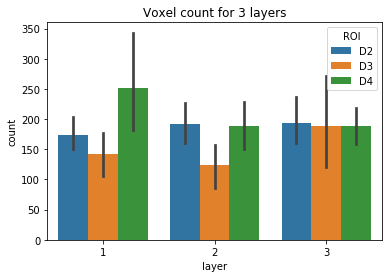

look at an ROI with 12 layers


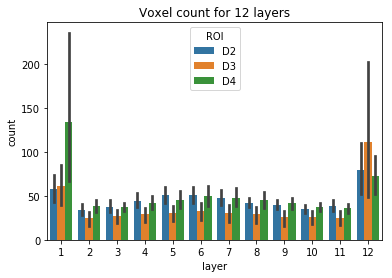

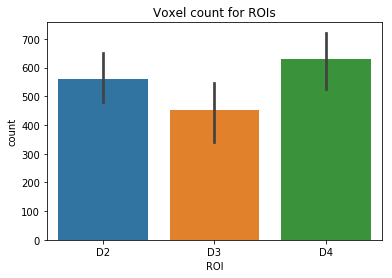

In [139]:

nrLayersList = [3, 12]

   

for nrLayers in nrLayersList:
    print(f'look at an ROI with {nrLayers} layers')
    subList = []
    voxelList = []
    roiList = []
    layerList = []

    for sub in subs: 
        for roi in digits:
            mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_{nrLayers}_layers_equivol.nii').get_fdata()


            for j in range(1,nrLayers+1):  # Compute bin averages
                layerRoi = mask == j

                nonZero = np.count_nonzero(layerRoi)
                subList.append(sub)
                voxelList.append(nonZero)
                roiList.append(roi)
                layerList.append(j)

    voxelCounts = pd.DataFrame({'subject': subList, 'ROI': roiList, 'count': voxelList, 'layer':layerList})            

    plt.figure()
    sns.barplot(data=voxelCounts, x='layer',y='count',hue='ROI')
    plt.title(f'Voxel count for {nrLayers} layers')
    plt.show()


subList = []
voxelList = []
roiList = []
layerList = []    
    
for sub in subs: 
    for roi in digits:
        mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_{nrLayers}_layers_equivol.nii').get_fdata()


        nonZero = np.count_nonzero(mask)
        subList.append(sub)
        voxelList.append(nonZero)
        roiList.append(roi)
        layerList.append(j)    

voxelCounts = pd.DataFrame({'subject': subList, 'ROI': roiList, 'count': voxelList, 'layer':layerList})            

plt.figure()
sns.barplot(data=voxelCounts, x='ROI',y='count')
plt.title(f'Voxel count for ROIs')
plt.show()

## Extract z-scores

In [143]:
digitsMaps = {'D2': 1, 'D3': 2, 'D4': 3}
for key in digitsMaps.keys():
    print(key)

D2
D3
D4


In [148]:
subList = []
dataList = []
modalityList = []
layerList = []
digitList = []
roiList = []


digitsMaps = {'D2': 1, 'D3': 2, 'D4': 3}
digits = ['D2', 'D3', 'D4']



for sub in subs:    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in ['BOLD','VASO']:
            
                
            for roi in digitsMaps.keys():
                mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_12_layers_equivol.nii').get_fdata()
                
                for digit in digits:
                    
                    data = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{digitsMaps[digit]}_scaled.nii.gz').get_fdata()



                    for j in range(1,13):  # Compute bin averages
                        
                        
                        layerRoi = mask == j
                        
                        mask_mean = np.mean(data[layerRoi.astype(bool)])

                        subList.append(sub)
                        dataList.append(mask_mean)
                        modalityList.append(modality)
                        layerList.append(j)
                        digitList.append(digit)
                        roiList.append(roi)



            
zscores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimDigit':digitList, 'readROI': roiList})

sub-02_ses-003_task-stim_run-001
sub-02_ses-003_task-stim_run-002
sub-05_ses-002_task-stim_run-001
sub-06_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-002
sub-09_ses-001_task-stim_run-001
sub-10_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-002
sub-12_ses-001_task-stim_run-003
sub-12_ses-001_task-stim_run-004
sub-15_ses-001_task-stim_run-001
sub-15_ses-001_task-stim_run-002
sub-15_ses-001_task-stim_run-003
sub-16_ses-001_task-stim_run-001


/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



sub-16_ses-001_task-stim_run-002
sub-16_ses-001_task-stim_run-003
sub-17_ses-001_task-stim_run-001
sub-17_ses-001_task-stim_run-002
sub-17_ses-001_task-stim_run-003
sub-18_ses-001_task-stim_run-001
sub-18_ses-001_task-stim_run-002
sub-18_ses-001_task-stim_run-003


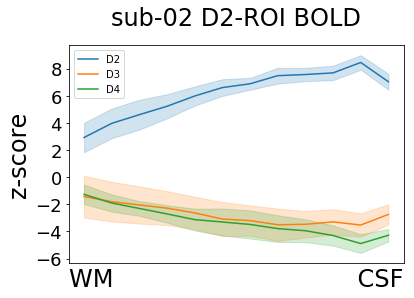

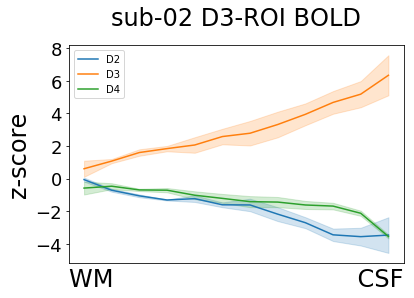

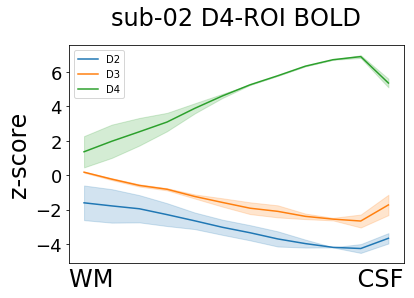

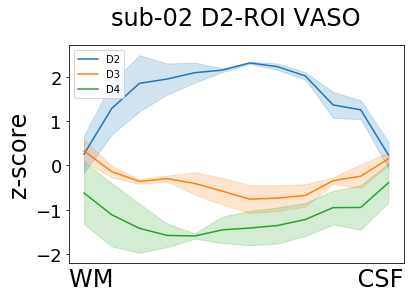

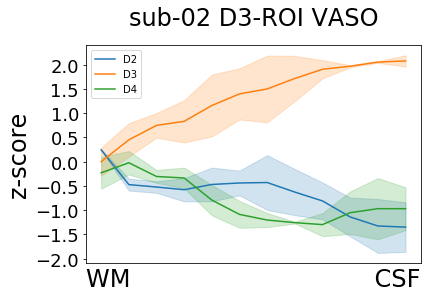

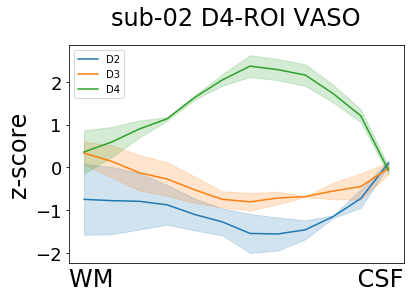

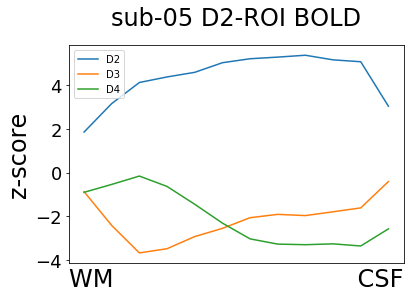

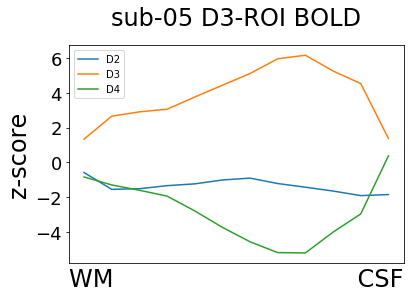

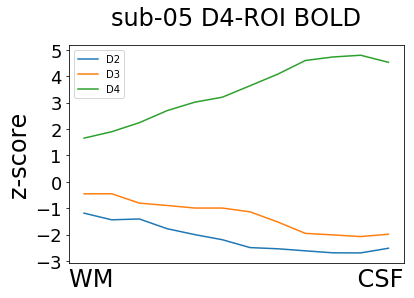

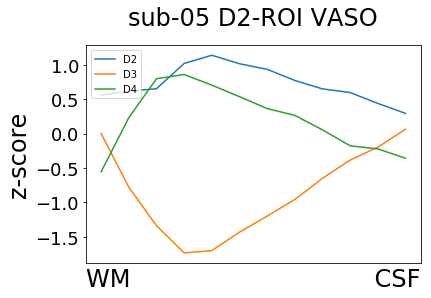

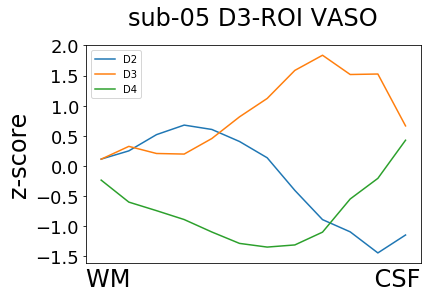

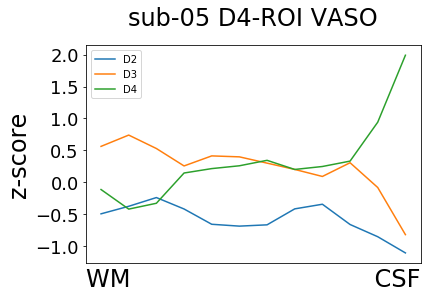

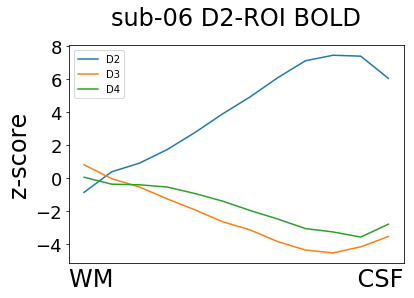

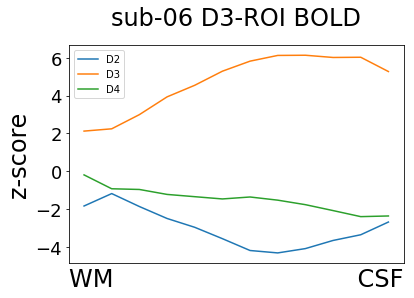

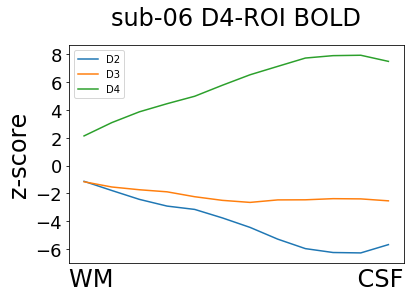

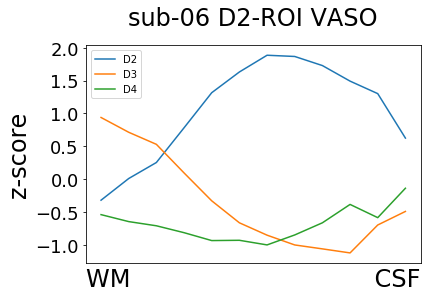

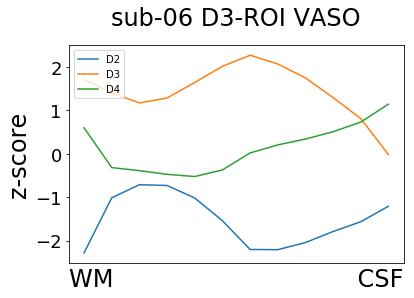

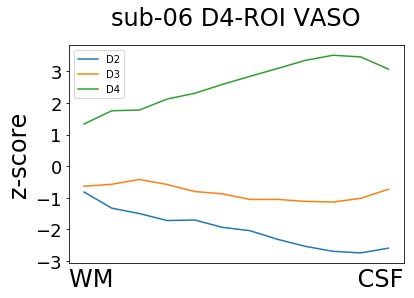

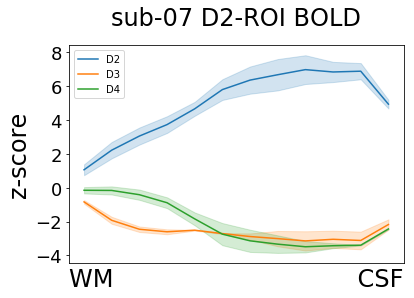

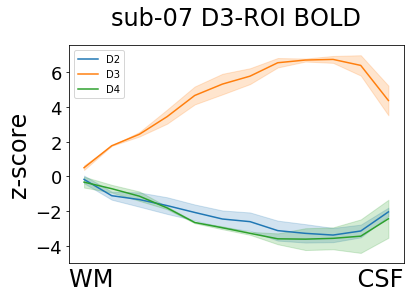

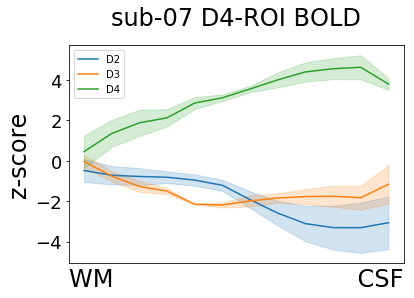

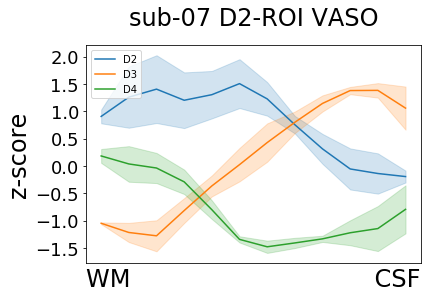

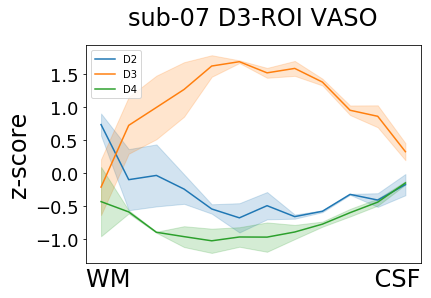

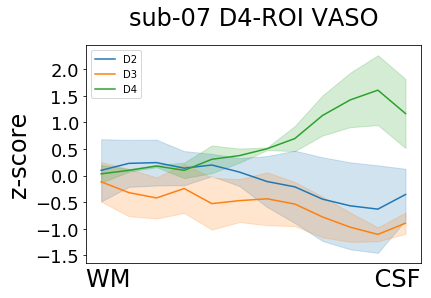

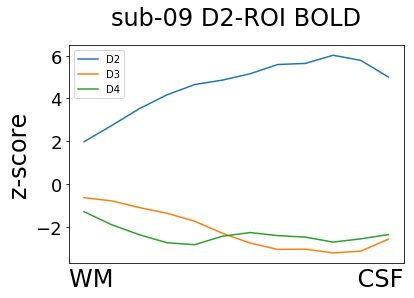

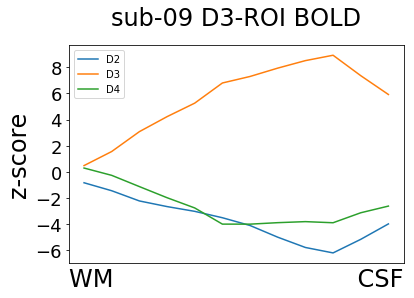

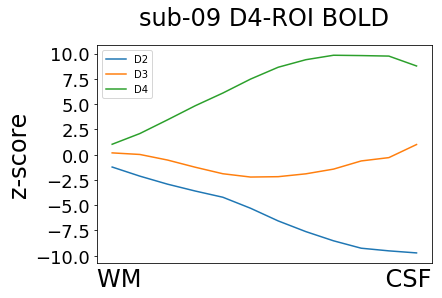

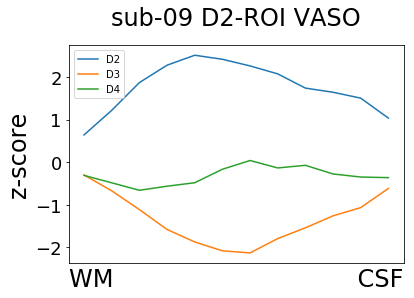

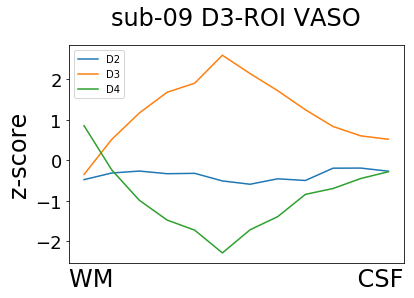

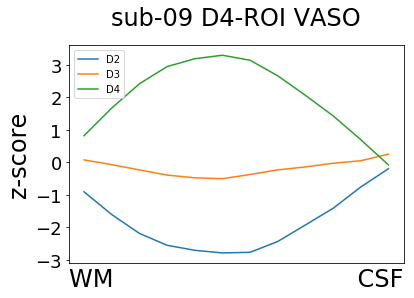

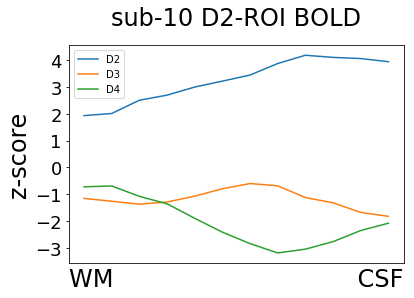

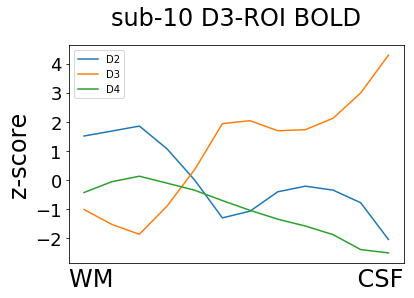

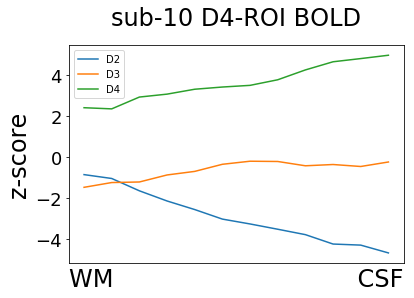

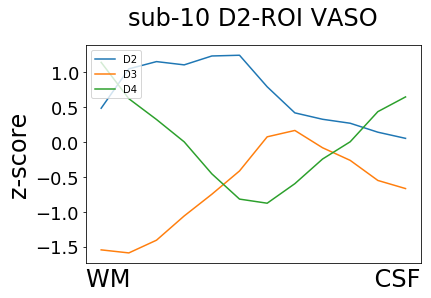

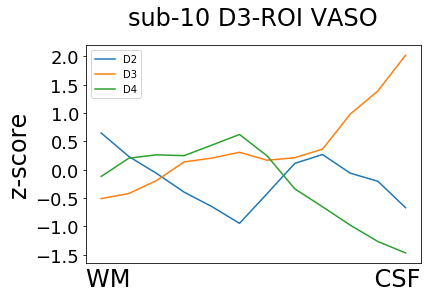

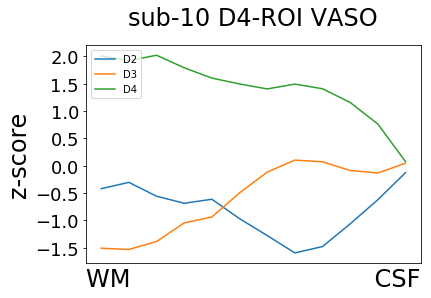

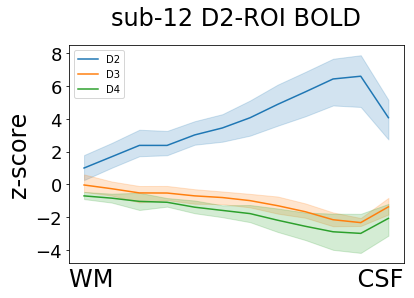

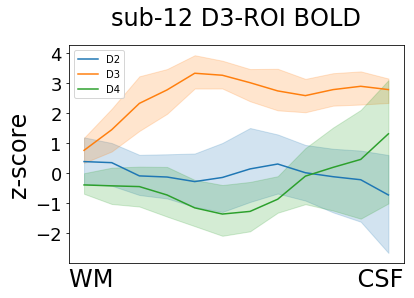

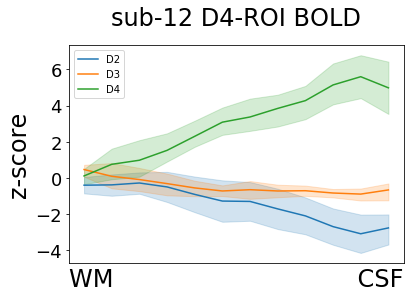

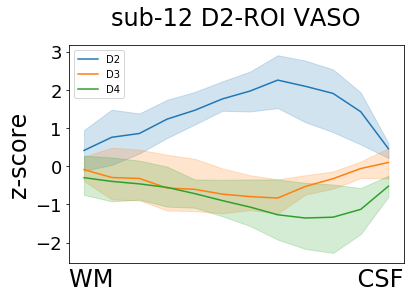

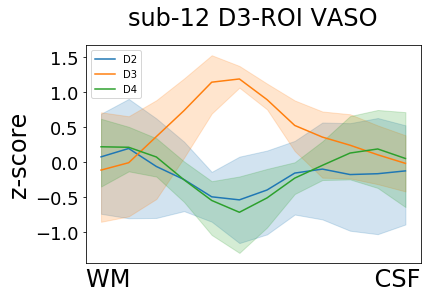

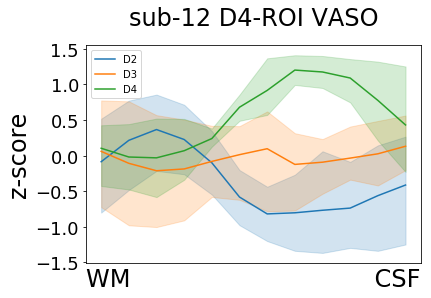

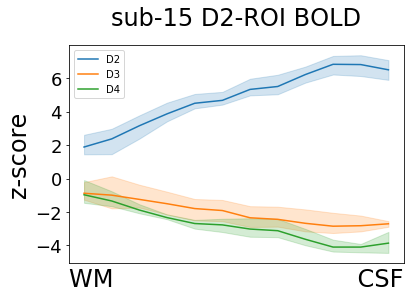

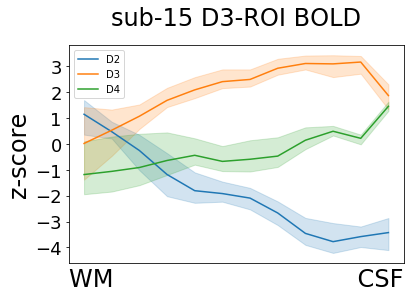

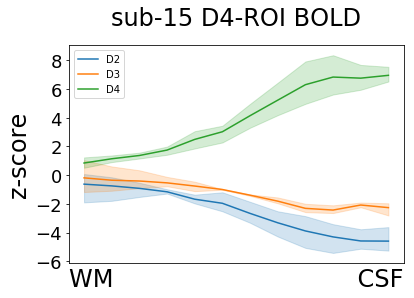

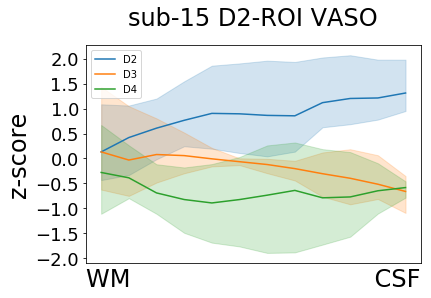

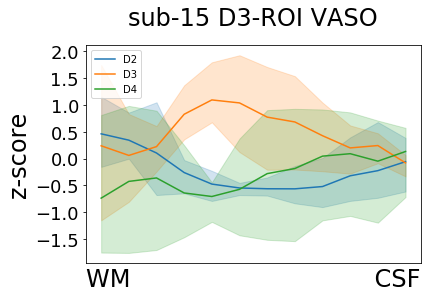

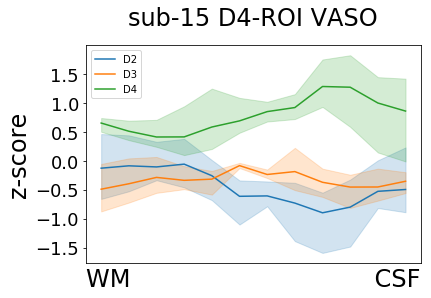

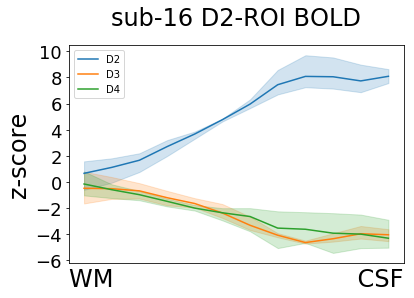

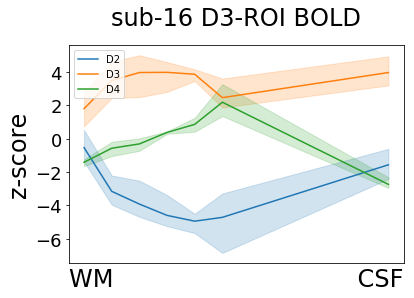

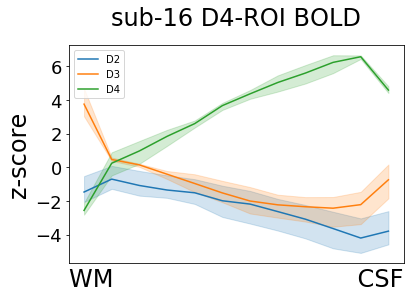

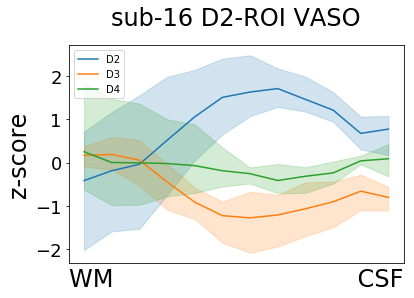

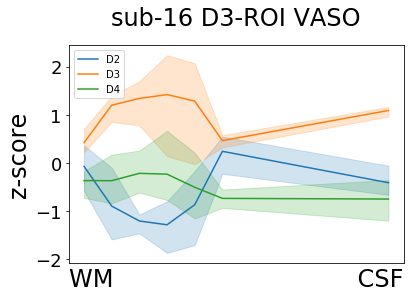

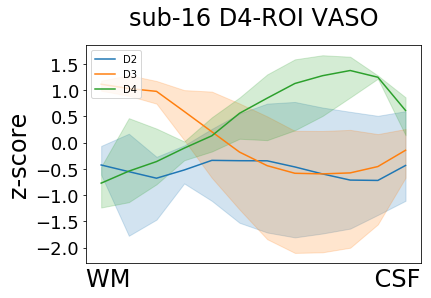

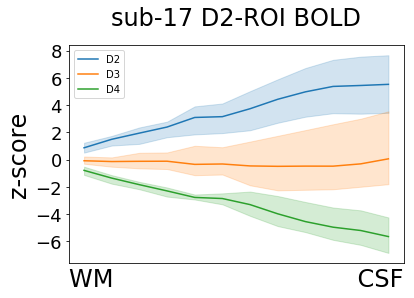

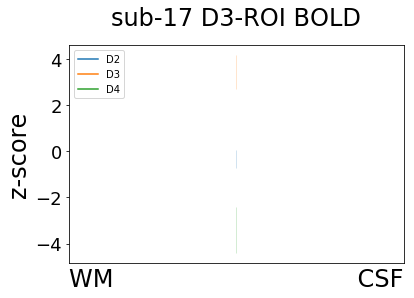

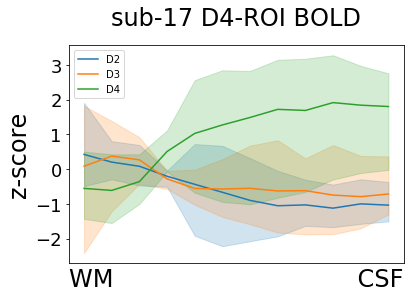

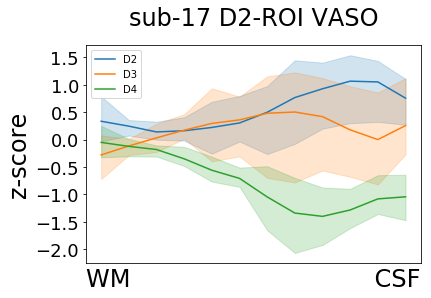

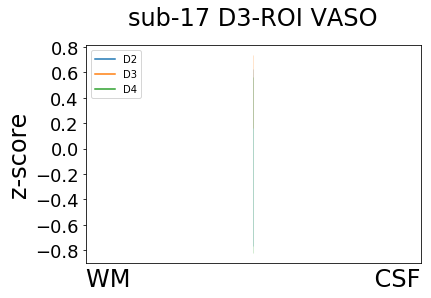

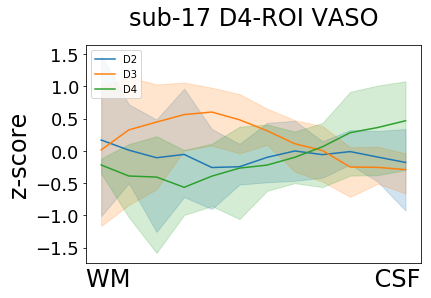

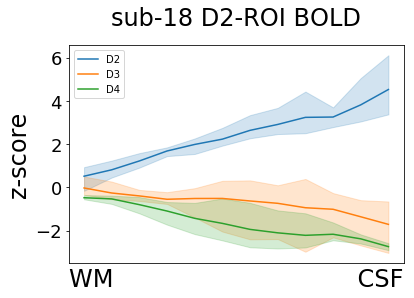

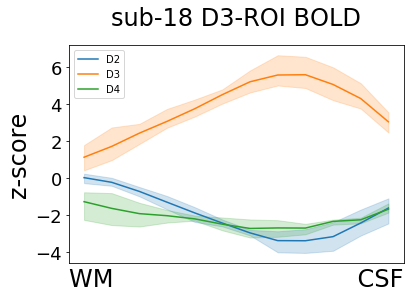

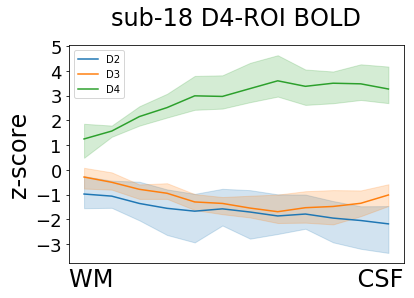

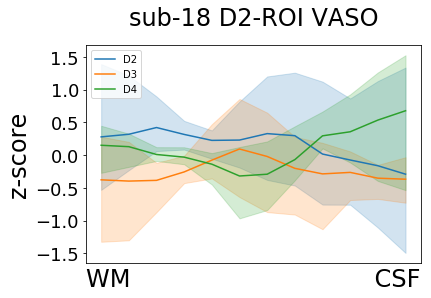

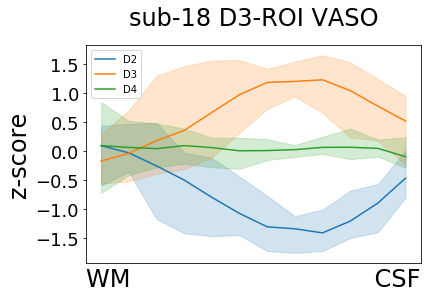

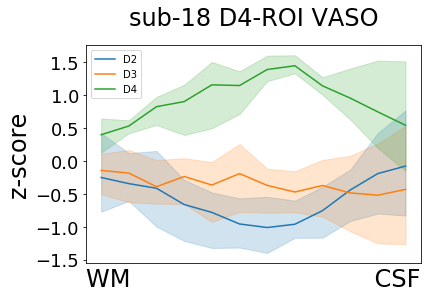

In [149]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

for sub in subs:
    for modality in ['BOLD','VASO']:

        for roi in digits:

            tmp = zscores.loc[(zscores['subject']==sub)&(zscores['modality']==modality)&(zscores['readROI']==roi)]

            sns.lineplot(data=tmp, x='layer', y='data', hue='stimDigit')


            plt.ylabel(f'z-score', fontsize=24)

            plt.title(f"{sub} {roi}-ROI {modality}", fontsize=24, pad=20)
            plt.xlabel('WM                                CSF', fontsize=24)
            plt.xticks([])
            yLimits = ax.get_ylim()
            # plt.ylim(0,yLimits[1])    

            plt.yticks(fontsize=18)

            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

            plt.legend(loc='upper left')


            # plt.savefig(f'{root}/Group_V1_{stimType}_zScoreProfile.png', bbox_inches = "tight")
            plt.show()

Text(25.4168,0.5,'bold_zstat')

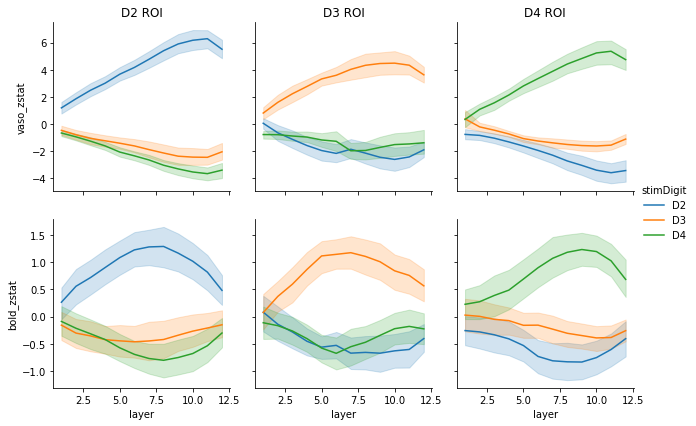

In [150]:
g = sns.FacetGrid(zscores, col="readROI", row="modality",hue = 'stimDigit', sharey="row")
g = g.map(sns.lineplot, 'layer', 'data').add_legend()
g.axes[0,0].set_title("D2 ROI")
g.axes[0,1].set_title("D3 ROI")
g.axes[0,2].set_title("D4 ROI")

g.axes[1,0].set_title("")
g.axes[1,1].set_title("")
g.axes[1,2].set_title("")

axes = g.axes.flatten()
axes[0].set_ylabel("vaso_zstat")
axes[3].set_ylabel("bold_zstat")


#g.savefig('/Volumes/elements/data/s1_anfunco_analysis/groupresults/average_withvar.png')

### Extract layer-timecourses from ROIs

In [386]:
modalities = ['BOLD', 'VASO']

In [151]:
def find_roi_box(array):

    smallestx = 1000
    largestx = 0

    smallesty = 1000
    largesty = 0

    smallestz = 1000
    largestz = 0

    for n in range(array.shape[-1]):
        for i in range(array.shape[-2]):
            indexes = np.nonzero(array[:,i,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallestx:
                    smallestx=indexes[0]
                if indexes[-1] > largestx:
                    largestx=indexes[-1]

                if n < smallestz:
                    smallestz=n
                if n > largestz:
                    largestz=n


        for i in range(array.shape[0]):
            indexes = np.nonzero(array[i,:,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallesty:
                    smallesty=indexes[0]
                if indexes[-1] > largesty:
                    largesty=indexes[-1]

    x_idx_range = slice(smallestx-1, largestx+1)
    y_idx_range = slice(smallesty-1, largesty+1)
    z_idx_range = slice(smallestz-1, largestz+1)

    return (x_idx_range, y_idx_range, z_idx_range)

In [153]:
modalities

['BOLD', 'VASO']

In [156]:
for sub in subs:
    
    os.system(f'mkdir {root}/derivatives/{sub}/func/timecourses')

    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]



    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    for digit in digits:
        print(digit)
        layerRoi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()

        for layer in np.unique(layerRoi)[1:]:
            print(f'layer: {layer}')
            digitLayer = layerRoi == layer

            box = find_roi_box(digitLayer)

            for modality in modalities:
                print(modality)
                timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
                print(f'nr timepoints: {timepoints}')
                timecourse = []

                for n in range(1, timepoints):
                    data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
                    dataArr = np.asarray(data.dataobj[box[0], box[1], box[2]])
                    trunc_mask = digitLayer[box[0], box[1], box[2]]

                    mask_mean = np.mean(dataArr[trunc_mask])
                    timecourse.append(mask_mean)

                with open(f'{root}/derivatives/{sub}/func/timecourses/{base}_{digit}_layer{int(layer)}_{modality}_timecourse.txt', "w") as f:
                    for item in timecourse:
                        f.write("%s\n" % item)

sub-02_ses-003_task-restBA3b_run-001
D2
layer: 1.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 2.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 3.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
D3
layer: 1.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 2.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 3.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
D4
layer: 1.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 2.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
layer: 3.0
BOLD
nr timepoints: 652
VASO
nr timepoints: 652
sub-05_ses-002_task-restBA3b_run-001
D2
layer: 1.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
layer: 2.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
layer: 3.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
D3
layer: 1.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
layer: 2.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
layer: 3.0
BOLD
nr timepoints: 332
VASO
nr timepoints: 332
D4
layer: 1.0
BOLD
nr time

## Permute over columns

In order to estimate the connectivity between our finger ROIs, we have to establish a baseline. We will do this through permutation testing. For this, we define columns using LN2_COLUMNS in LayNii. Additinal care will be taken that the column size matches the size of oour actual ROIs.

### Define columns and match size

We want to match our column size with size of our ROIs. Unfortunately, setting a column size is not possible in LayNii. Therefore, we will go thorugh some iterations.

In [7]:
digits = ['D2', 'D3', 'D4']

In [14]:
substmp[1:2]

['sub-15']

sub-18
Our mean ROI size is: 373.3333333333333 voxels
testing 1000 columns
Our current average column size is: 388.45 voxels


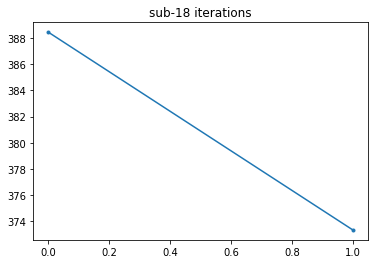

In [245]:
for sub in ['sub-18']:
    
    print(sub)
    
    # find roi voxel count
    roiVoxels = []
    for digit in digits:
        mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        nonZero = np.count_nonzero(mask)
        roiVoxels.append(nonZero)
    meanCountDigits = np.mean(np.array(roiVoxels))
    
    print(f'Our mean ROI size is: {meanCountDigits} voxels')
    
    upperLim = meanCountDigits + ((meanCountDigits/100)*10)
    lowerLim = meanCountDigits - ((meanCountDigits/100)*10)
    
    meanCount = 0
    
    iterations = []
    
    columnCount = 1000

    
    os.system(f'mkdir -p {root}/derivatives/{sub}/anat/findColSize/iterate')
    
    while meanCount > upperLim or meanCount < lowerLim:
        print(f'testing {columnCount} columns')
        
        os.system(f'LN2_COLUMNS -rim {root}/derivatives/{sub}/anat/{sub}_rim.nii.gz -midgm {root}/derivatives/{sub}/anat/{sub}_rim_midGM_equidist.nii.gz -nr_columns {columnCount} -output {root}/derivatives/{sub}/anat/findColSize/iterate/{sub}')

        cols = nb.load(f'{root}/derivatives/{sub}/anat/findColSize/iterate/{sub}_columns{columnCount}.nii').get_fdata()

        voxelCounts = []

        for column in np.unique(cols)[1:]:

            roi = cols == column
            nonZero = np.count_nonzero(roi)
            voxelCounts.append(nonZero)

        meanCount = np.mean(np.array(voxelCounts))
        
        iterations.append(meanCount)
        
        print(f'Our current average column size is: {meanCount} voxels')
        
        # if the average column has more voxels than our predefined count, we have to increase the number of columns
        # to make the voxel number smaller
        if meanCount > upperLim:
            columnCount = columnCount + 20
        # the opposite is true if the average column has less voxels than our ROIs    
        if meanCount < lowerLim:
            columnCount = columnCount - 20
            
    
    iterations.append(meanCountDigits)
    plt.figure()
    plt.plot(iterations, marker='.')
    plt.title(f'{sub} iterations')
    plt.show()
    os.system(f'LN2_COLUMNS -rim {root}/derivatives/{sub}/anat/{sub}_rim.nii.gz -midgm {root}/derivatives/{sub}/anat/{sub}_rim_midGM_equidist.nii.gz -nr_columns {columnCount} -output {root}/derivatives/{sub}/anat/findColSize/{sub}')
    os.system(f'rm -r {root}/derivatives/{sub}/anat/findColSize/iterate')

    
    

### Timecourse extraction from ROIs

To speed up the process of timecourse extraction, we truncate the timeseries to the box surrounding our ROIs.

This still takes a lot of time. Therefore, we will test a few options.

1. extracting information from all columns at the same time.

In [210]:
import time

In [282]:
start_time = time.time()



for sub in subs[1:]:
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_column*.nii')[0]
    cols = nb.load(colFile).get_fdata()

    idx_columns = np.unique(cols)[1:].astype("int")



#     colRoi = cols != 0
#     colBox = find_roi_box(colRoi)

#     colsArr = np.asarray(nb.load(colFile).dataobj[colBox[0], colBox[1], colBox[2]])



    layers3 = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii').get_fdata()
    nrlayers3 = len(np.unique(layers)[1:])


#     layersFile3 = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii')
#     laysArr3 = np.asarray(layersFile.dataobj[colBox[0], colBox[1], colBox[2]])


    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))
    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)

    # find number of columns
    nrColumns = len(idx_columns)

    for modality in ['VASO', 'BOLD']:
#     for modality in ['VASO']:
        print(f'processing {modality}...')

        timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
        timecourse03 = np.zeros((nrColumns, timepoints, nrlayers3))


        for n in range(0, timepoints):
            data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
#             dataArr = np.asarray(data.dataobj[colBox[0], colBox[1], colBox[2]])
            dataArr = data.get_fdata()

            for column in idx_columns:
#                 print(f'processing column {column}')
                tmpCol = (cols == column).astype(int)


                for layer in np.unique(layers3)[1:]:
#                     print(f"layer {layer}")
                    tmpLayer = (layers3 == layer).astype(int)
                    intersection = np.multiply(tmpCol, tmpLayer).astype("float")
        

                    idxIntersection = intersection == 1


                    mask_mean = np.mean(dataArr[idxIntersection])
#                     print(mask_mean)

                    timecourse03[int(column)-1, n, int(layer)-1] = mask_mean
    

    
    
        print('saving...')
        for column in idx_columns:
            for layer in np.unique(layers3)[1:]:
                np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_03layers_layer{int(layer):02d}_timecourse.txt', timecourse03[int(column)-1, :, int(layer)-1], delimiter='/n', fmt='%1.4f')


endTime = time.time()
print("--- %s seconds ---" % (endTime - start_time))


sub-02_ses-003_task-restBA3b_run-001
processing VASO...
saving...
processing BOLD...
saving...
--- 117300.82975459099 seconds ---


In [276]:

ni_img = nb.Nifti1Image(tmpCol, nb.load(colFile).affine)
nb.save(ni_img, f'{root}/derivatives/sub-02/anat/findColSize/sub-02_col{column}.nii')

the absolute time takefn for one modality will be 

In [253]:
timeTaken = (endTime - start_time)
print("--- %s minutes ---" % (timeTaken/60))

--- 3.361095607280731 minutes ---


In [254]:
((3.361)*timepoints)/60

35.2905

In [ ]:
313/60

In [259]:
timecourse

array([[89.06640625, 84.78571429, 84.28571429],
       [88.73046875, 85.08928571, 84.71428571],
       [89.02734375, 88.01785714, 86.71428571],
       ...,
       [85.99609375, 91.26785714, 91.        ],
       [82.90234375, 90.14285714, 93.42857143],
       [82.80859375, 86.05357143, 90.71428571]])

2. extracting from a column at a time

In [262]:
start_time = time.time()

for sub in subs:
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_column*.nii')[0]
    cols = nb.load(colFile).get_fdata()
    
    idx_columns = np.unique(cols)[1:].astype("int")

    layers = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii').get_fdata()
    nrlayers = len(np.unique(layers)[1:])

    

    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))
    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    
    for column in idx_columns[0:1]:
        print(f'processing column {column}')
        tmpCol = (cols == column).astype(int)


        colRoi = cols == column

        box = find_roi_box(colRoi)


        colRoiTrunc = colRoi[box[0], box[1], box[2]]
#         for modality in ['VASO', 'BOLD']:
        for modality in ['VASO', 'BOLD']:

            timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
            timecourse = np.zeros((timepoints, nrlayers))


            for n in range(0, timepoints):
                data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
                dataArr = np.asarray(data.dataobj[box[0], box[1], box[2]])


                for layer in np.unique(layers)[1:]:
    #                 print(f"layer {layer}")
                    tmpLayer = (layers == layer).astype(int)
                    intersection = np.multiply(tmpCol, tmpLayer).astype("float")

                    idxIntersection = intersection == 1

                    idxIntersectionTrunc = idxIntersection[box[0], box[1], box[2]]

                    mask_mean = np.mean(dataArr[idxIntersectionTrunc])
    #                 print(mask_mean)

                    timecourse[n, int(layer)-1] = mask_mean

            for layer in np.unique(layers)[1:]:
    #             print(layer)
                np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_layer{int(layer):02d}_timecourse2.txt', timecourse[:,int(layer)-1], delimiter='/n', fmt='%1.4f')
        endTime = time.time()
        print("--- %s seconds ---" % (endTime - start_time))


sub-18_ses-001_task-restBA3b_run-001
processing column 1
--- 5.762841463088989 seconds ---


In [256]:
timeTaken = (endTime - start_time)
print("--- %s minutes ---" % (timeTaken/60))

--- 2.250413664182027 minutes ---


In [258]:
((timeTaken/60)*len(idx_columns))/60

37.50689440303379

In [260]:
for layer in np.unique(layers)[1:]:
#             print(layer)
    np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_layer{int(layer):02d}_timecourse.txt', timecourse[:,int(layer)-1], delimiter='/n', fmt='%1.4f')


The approach above might be error prone. Therefore, we will test for one column whether our code gives us the same results as a conventional approach. The likelyhood that the results are simlar by chance is very low.

In [945]:
colNii = nb.load(f'{root}/derivatives/sub-15/anat/findColSize/sub-15_columns300.nii')
colAff = colNii.affine
colData =colNii.get_fdata()
col1 = (colData == 1).astype(int)

layNii = nb.load(f'{root}/derivatives/sub-15/anat/sub-15_3_layers_equivol.nii')
layData =layNii.get_fdata()
lay1 = (layData == 1).astype(int)

intersection = np.multiply(col1, lay1).astype("float")

ni_img = nb.Nifti1Image(intersection, colAff)
nb.save(ni_img, f'{root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii')

In [947]:
timepoints = nb.load(f'{root}/derivatives/sub-15/func/sub-15_ses-001_task-restBA3b_run-001_VASO.nii.gz').get_fdata().shape[-1]

os.system(f'3dmaskave -quiet -mask {root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii {root}/derivatives/sub-15/func/scaledVolumes/sub-15_ses-001_task-restBA3b_run-001_VASO_vol_1000_scaled.nii > {root}/derivatives/sub-15/anat/findColSize/test.txt')

for n in range(1, timepoints):
    os.system(f'3dmaskave -quiet -mask {root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii {root}/derivatives/sub-15/func/scaledVolumes/sub-15_ses-001_task-restBA3b_run-001_VASO_vol_{n+1000}_scaled.nii >> {root}/derivatives/sub-15/anat/findColSize/test.txt')


In [948]:
test = np.loadtxt(f'{root}/derivatives/sub-15/anat/findColSize/test.txt', delimiter='\n')
actual = np.loadtxt(f'{root}/derivatives/sub-15/func/timecourses/sub-15_ses-001_task-restBA3b_run-001_VASO_col001_layer01_timecourse.txt', delimiter='\n')

In [949]:
test == actual

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Cool, this checks out. Let's continue with the permutation testing.

### Actual permutation

We start by creating an array that contains all column numbers. From this we will draw a triplet in each iteration.

In [958]:
columnNrs = np.arange(1,301)

Then, we can set the number of iterations we want to do.

In [950]:
nrPermutations = 10

And here we go

In [ ]:
from numpy import array
conditions = {
    'seed': array([1,0])}



for n in range(nrPermutations):
    
    columns = random.choices(columnNrs, k=3)
    
    print(columns)


    sub_list=[]
    seed_rois=[]
    read_rois=[]
    layer_val=[]
    layerNr=[]
    seedDepths_list=[]


    for sub in ['sub-15']:
        print(sub)
        
        
        layerData = nb.load(f'{root}/derivatives/sub-15/anat/sub-15_3_layers_equivol.nii')
        layData =layNii.get_fdata()
        
        
        roi = nb.load(f'{root}/derivatives/sub-15/anat/findColSize/sub-15_columns300.nii').get_fdata()
        allCols = np.zeros(roi.shape)


        for column in columns:
            
            col = (colData == column).astype(int)
            allCols = np.add(allCols, roi)

        allCols = (allCols>0).astype(int)


        box = find_roi_box(allCols)

        for seedlayer in range(1,4):

            for seedROI in columns:
                print(f'seed : {seedROI}')
                nonseeds = columns.copy()
                nonseeds.remove(seedROI)

                timecourse = np.loadtxt(f'{root}/derivatives/{sub}/func/timecourses/{sub}_ses-001_task-restBA3b_run-001_{modality}_col{int(column):03d}_layer{seedlayer:02d}_timecourse.txt', delimiter='\n')[:-1]
                print(timecourse.shape[0])

                frametimes = np.linspace(0, (timecourse.shape[0] - 1) * 1.929500, timecourse.shape[0])

                design_matrix = make_first_level_design_matrix(frametimes, hrf_model='spm',drift_model=None,
                                                           add_regs=timecourse,
                                                           add_reg_names=["seed"])

                fmri_glm = FirstLevelModel(mask_img=False, standardize=True)

                fmri_glm = fmri_glm.fit(f'{root}/derivatives/{sub}/func/{sub}_ses-001_task-restBA3b_run-001_{modality}_scaled.nii', design_matrices=design_matrix)

                statMap = fmri_glm.compute_contrast(conditions['seed'], output_type='effect_size').get_fdata()


                for readROI in nonseeds:
                    print(f'read from: {readROI}')
                    
                    roiTmp = (roi == column).astype(int)[box[0], box[1], box[2]]
                    
                    
                    profile = []

                    for layer in np.unique(layData)[1:]:

                        layerRoi = (layData == layer).astype(int)[box[0], box[1], box[2]]
                        
                        intersect = np.multiply(layerRoi, roiTmp)

                        mask_mean = np.mean(statMap[intersect])
                        profile.append(mask_mean)

                    arr = np.array(profile)
                    arr = arr-np.mean(arr)

                    for n, val in enumerate(arr):                
                        layer_val.append(float(np.copy(val)))
                        layerNr.append(n+1)
                        seed_rois.append(str(seedROI))
                        read_rois.append(str(readROI))
                        sub_list.append(sub)
                        seedDepths_list.append("%02d" % (int(seedlayer),))


    permuted_columns = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
    permuted_columns['subject']=sub_list
    permuted_columns['seed_roi']=seed_rois
    permuted_columns['read_roi']=read_rois
    permuted_columns['layer']=layerNr
    permuted_columns['layer_val']=layer_val
    permuted_columns['depth']=seedDepths_list

[17, 120, 67]
sub-15
seed : 17
685
read from: 120


In [160]:
for sub in subs:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]



    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)

    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)

    for modality in modalities:

        timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
        data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_1000_scaled.nii')
        dataArr = data.get_fdata()[box[0], box[1], box[2]]
        newData = np.zeros((dataArr.shape[0],dataArr.shape[1],dataArr.shape[2],timepoints))    
        affine = data.affine


        for n in range(0, timepoints):
            vol = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii').get_fdata()[box[0], box[1], box[2]]
            newData[:,:,:,n] = vol

        ni_img = nb.Nifti1Image(newData[:,:,:,:-1], affine)
        nb.save(ni_img, f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii')

sub-02_ses-003_task-restBA3b_run-001
sub-05_ses-002_task-restBA3b_run-001
sub-06_ses-001_task-restBA3b_run-001
sub-07_ses-001_task-restBA3b_run-001
sub-09_ses-001_task-restBA3b_run-001
sub-10_ses-001_task-restBA3b_run-001
sub-12_ses-001_task-restBA3b_run-001
sub-15_ses-001_task-restBA3b_run-001
sub-16_ses-001_task-restBA3b_run-001
sub-17_ses-001_task-restBA3b_run-001
sub-18_ses-001_task-restBA3b_run-001


In [161]:
for sub in subs:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]



    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)


    for modality in modalities:

        data = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
        
        os.system(f'3drefit -TR 1.9295 {data}')

sub-02_ses-003_task-restBA3b_run-001
sub-05_ses-002_task-restBA3b_run-001
sub-06_ses-001_task-restBA3b_run-001
sub-07_ses-001_task-restBA3b_run-001
sub-09_ses-001_task-restBA3b_run-001
sub-10_ses-001_task-restBA3b_run-001
sub-12_ses-001_task-restBA3b_run-001
sub-15_ses-001_task-restBA3b_run-001
sub-16_ses-001_task-restBA3b_run-001
sub-17_ses-001_task-restBA3b_run-001
sub-18_ses-001_task-restBA3b_run-001


In [163]:
test

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-stim_run-001_VASO_scaled.nii.gz',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-stim_run-002_VASO_scaled.nii.gz']

In [935]:
from numpy import array
conditions = {
    'seed': array([1,0])}

sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]


for sub in ['sub-15', 'sub-16']:
    print(sub)

    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)

    for seedlayer in range(1,4):

        for seedROI in digits:
            print(f'seed : {seedROI}')
            nonseeds = digits.copy()
            nonseeds.remove(seedROI)

            timecourse = np.loadtxt(f'{root}/derivatives/{sub}/func/timecourses/{sub}_ses-001_task-restBA3b_run-001_VASO_{seedROI}_layer{seedlayer}_timecourse.txt', delimiter='\n')
            print(timecourse.shape[0])
            
            frametimes = np.linspace(0, (timecourse.shape[0] - 1) * 1.929500, timecourse.shape[0])

            design_matrix = make_first_level_design_matrix(frametimes, hrf_model='spm',drift_model=None,
                                                       add_regs=timecourse,
                                                       add_reg_names=["seed"])
            
            fmri_glm = FirstLevelModel(mask_img=False, standardize=True)

            fmri_glm = fmri_glm.fit(f'{root}/derivatives/{sub}/func/{sub}_ses-001_task-restBA3b_run-001_{modality}_scaled.nii', design_matrices=design_matrix)
            
            statMap = fmri_glm.compute_contrast(conditions['seed'], output_type='effect_size').get_fdata()


            for readROI in nonseeds:
                print(f'read from: {readROI}')
                
                roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{readROI}_12_layers_equivol.nii').get_fdata()[box[0], box[1], box[2]]
                profile = []

                for layer in np.unique(roi)[1:]:

                    layerRoi = roi == layer

                    mask_mean = np.mean(statMap[layerRoi])
                    profile.append(mask_mean)

                arr = np.array(profile)
                arr = arr-np.mean(arr)

                for n, val in enumerate(arr):                
                    layer_val.append(float(np.copy(val)))
                    layerNr.append(n+1)
                    seed_rois.append(str(seedROI))
                    read_rois.append(str(readROI))
                    sub_list.append(sub)
                    seedDepths_list.append("%02d" % (int(seedlayer),))

sub-15
seed : D2
685
read from: D3
read from: D4
seed : D3
685
read from: D2
read from: D4
seed : D4
685
read from: D2
read from: D3
seed : D2
685
read from: D3
read from: D4
seed : D3
685
read from: D2
read from: D4
seed : D4
685
read from: D2
read from: D3
seed : D2
685
read from: D3
read from: D4
seed : D3
685
read from: D2
read from: D4
seed : D4
685
read from: D2
read from: D3
sub-16
seed : D2
619
read from: D3
read from: D4
seed : D3
619
read from: D2
read from: D4
seed : D4
619
read from: D2
read from: D3
seed : D2
619
read from: D3
read from: D4
seed : D3
619
read from: D2
read from: D4
seed : D4
619
read from: D2
read from: D3
seed : D2
619
read from: D3
read from: D4
seed : D3
619
read from: D2
read from: D4
seed : D4
619
read from: D2
read from: D3


In [936]:
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



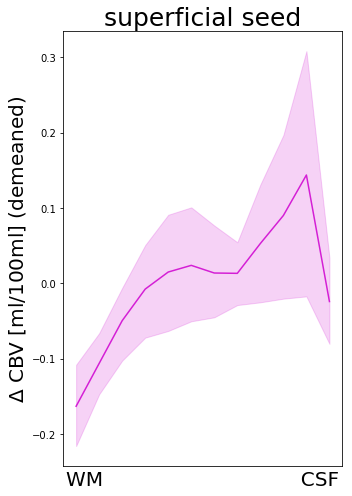

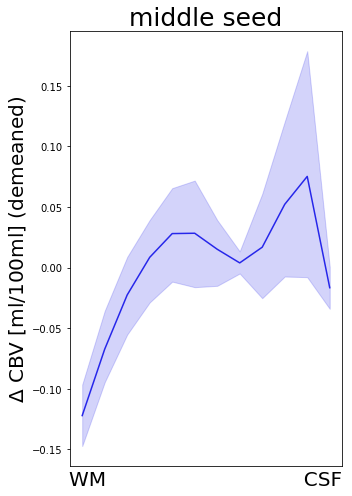

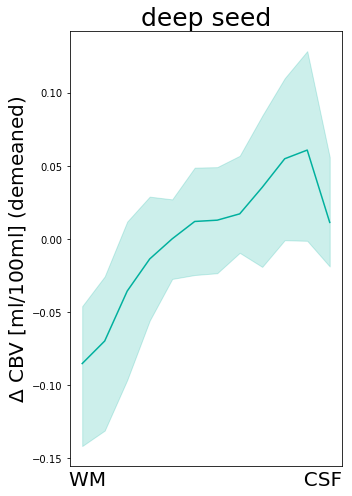

In [939]:
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list



colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['01','02','03']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']


for depth,seed_label,color in zip(depths,seed_labels,colors):
    fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))
    
    plt.title('%s seed'%(seed_label), fontsize=25)


    sns.lineplot(ax=ax, data = sub_data.loc[(sub_data['depth']==depth)&(sub_data['subject']=='sub-16')], x='layer', y='layer_val',color=color)
    ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

    plt.xlabel("WM                               CSF",fontsize=20)

    plt.xticks([],[])

In [197]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
                    
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            print(nrVolumes)

            replacements = {'SUB': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}



            with open(f"{fsfDir}/restingStateDesignTemplate.fsf") as infile:
                with open(f"{fsfDir}/{base}_{modality}.fsf", 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

BOLD
sub-02_ses-003_task-restBA3b_run-001
651
VASO
sub-02_ses-003_task-restBA3b_run-001
651
BOLD
sub-05_ses-002_task-restBA3b_run-001
331
VASO
sub-05_ses-002_task-restBA3b_run-001
331
BOLD
sub-06_ses-001_task-restBA3b_run-001
317
VASO
sub-06_ses-001_task-restBA3b_run-001
317
BOLD
sub-07_ses-001_task-restBA3b_run-001
331
VASO
sub-07_ses-001_task-restBA3b_run-001
331
BOLD
sub-09_ses-001_task-restBA3b_run-001
331
VASO
sub-09_ses-001_task-restBA3b_run-001
331
BOLD
sub-10_ses-001_task-restBA3b_run-001
331
VASO
sub-10_ses-001_task-restBA3b_run-001
331
BOLD
sub-12_ses-001_task-restBA3b_run-001
331
VASO
sub-12_ses-001_task-restBA3b_run-001
329
BOLD
sub-15_ses-001_task-restBA3b_run-001
685
VASO
sub-15_ses-001_task-restBA3b_run-001
685
BOLD
sub-16_ses-001_task-restBA3b_run-001
621
VASO
sub-16_ses-001_task-restBA3b_run-001
619
BOLD
sub-17_ses-001_task-restBA3b_run-001
619
VASO
sub-17_ses-001_task-restBA3b_run-001
617
BOLD
sub-18_ses-001_task-restBA3b_run-001
631
VASO
sub-18_ses-001_task-restBA3b_

In [202]:
for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
                    
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            mergedConfs = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_mergedConfounds.txt')
            
            mergedConfs = mergedConfs[:-1, :]
            np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_mergedConfounds.txt', mergedConfs, delimiter=' ')

BOLD
sub-02_ses-003_task-restBA3b_run-001
VASO
sub-02_ses-003_task-restBA3b_run-001
BOLD
sub-05_ses-002_task-restBA3b_run-001
VASO
sub-05_ses-002_task-restBA3b_run-001
BOLD
sub-06_ses-001_task-restBA3b_run-001
VASO
sub-06_ses-001_task-restBA3b_run-001
BOLD
sub-07_ses-001_task-restBA3b_run-001
VASO
sub-07_ses-001_task-restBA3b_run-001
BOLD
sub-09_ses-001_task-restBA3b_run-001
VASO
sub-09_ses-001_task-restBA3b_run-001
BOLD
sub-10_ses-001_task-restBA3b_run-001
VASO
sub-10_ses-001_task-restBA3b_run-001
BOLD
sub-12_ses-001_task-restBA3b_run-001
VASO
sub-12_ses-001_task-restBA3b_run-001
BOLD
sub-15_ses-001_task-restBA3b_run-001
VASO
sub-15_ses-001_task-restBA3b_run-001
BOLD
sub-16_ses-001_task-restBA3b_run-001
VASO
sub-16_ses-001_task-restBA3b_run-001
BOLD
sub-17_ses-001_task-restBA3b_run-001
VASO
sub-17_ses-001_task-restBA3b_run-001
BOLD
sub-18_ses-001_task-restBA3b_run-001
VASO
sub-18_ses-001_task-restBA3b_run-001


In [203]:
for sub in subs[1:]:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*rest*.fsf'))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
        print(f'1: {feat1}')
        print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-05_ses-002_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-05_ses-002_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-06_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-06_ses-001_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-07_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-07_ses-001_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-09_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/der

In [164]:
os.system(f'mkdir {root}/derivatives/sub-02/func/restResults')

0

In [178]:
mappingDict = {'1': {'digit': 'D2', 'seedLayer': 1},
              '2': {'digit': 'D2', 'seedLayer': 2},
              '3': {'digit': 'D2', 'seedLayer': 3},
              '4': {'digit': 'D3', 'seedLayer': 1},
              '5': {'digit': 'D3', 'seedLayer': 2},
              '6': {'digit': 'D3', 'seedLayer': 3},
              '7': {'digit': 'D4', 'seedLayer': 1},
              '8': {'digit': 'D4', 'seedLayer': 2},
              '9': {'digit': 'D4', 'seedLayer': 3},}

In [ ]:
{root}/derivatives/{sub}/func/{sub}_ses-003_task-restBA3b_run-001_VASO.feat/stats/pe{pe}.nii.gz

In [206]:
sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]

for sub in subs:
    print(sub)
    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)
    
    
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))



    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    for pe in range(1,10):
        seedDigit = mappingDict[str(pe)]['digit']
        seedLayer = mappingDict[str(pe)]['seedLayer']
        print(f'Seed: {seedDigit} layer {seedLayer}')
        
        nonseeds = digits.copy()
        nonseeds.remove(seedDigit)
        
        resultsMap = nb.load(f'{root}/derivatives/{sub}/func/{base}_VASO.feat/stats/pe{pe}.nii.gz').get_fdata()
        
        for readROI in nonseeds:
            print(f'read from: {readROI}')
                
            roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{readROI}_12_layers_equivol.nii').get_fdata()[box[0], box[1], box[2]]
        
            profile = []

            for layer in np.unique(roi)[1:]:

                layerRoi = roi == layer

                mask_mean = np.mean(resultsMap[layerRoi])
                profile.append(mask_mean)

            arr = np.array(profile)
            arr = arr-np.mean(arr)

            for n, val in enumerate(arr):                
                layer_val.append(float(np.copy(val)))
                layerNr.append(n+1)
                seed_rois.append(str(seedDigit))
                read_rois.append(str(readROI))
                sub_list.append(sub)
                seedDepths_list.append("%02d" % (int(seedLayer),))

sub-02
sub-02_ses-003_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3
sub-05
sub-05_ses-002_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3
sub-06
sub-06_ses-001_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 laye

FileNotFoundError: No such file or no access: '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/func/sub-17_ses-001_task-restBA3b_run-001_VASO.feat/stats/pe1.nii.gz'

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



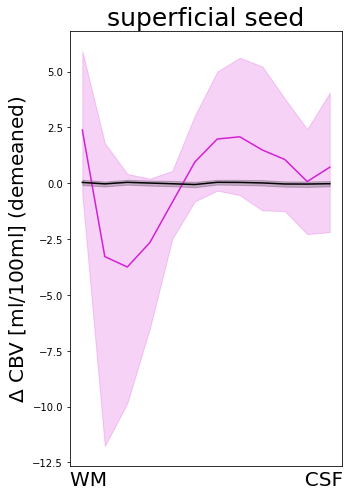

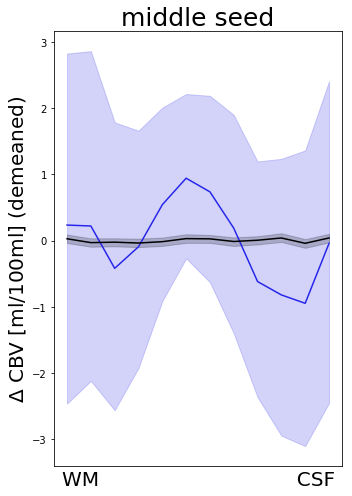

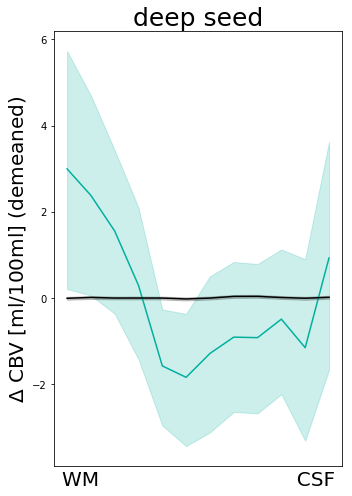

In [374]:
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list



colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['01','02','03']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']


for depth,seed_label,color in zip(depths,seed_labels,colors):
    fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))
    
    plt.title('%s seed'%(seed_label), fontsize=25)


    sns.lineplot(ax=ax, data = sub_data.loc[(sub_data['depth']==depth)], x='layer', y='layer_val',color=color)
    sns.lineplot(ax=ax, data = permutSub_data.loc[(permutSub_data['depth']==depth)], x='layer', y='layer_val',color='black')

    ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

    plt.xlabel("WM                               CSF",fontsize=20)

    plt.xticks([],[])

### Anova

In [415]:
from statsmodels.stats.anova import AnovaRM


for depth,seed_label,color in zip(depths,seed_labels,colors):
    data2 = sub_data.loc[(sub_data['depth']==depth)]

    results = AnovaRM(data=data2, depvar='layer_val', subject='subject', within=['layer'],aggregate_func='mean').fit()
    print(results)

               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
layer  2.4053 11.0000 88.0000 0.0116

               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
layer  0.1845 11.0000 88.0000 0.9981

               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
layer  2.1098 11.0000 88.0000 0.0275



### T-tests

### assumptions

In [417]:
for depth,seed_label,color in zip(depths,seed_labels,colors):

    for layer in sub_data['layer'].unique():
    #     fig, axs = plt.subplots(1, 2)

        data1 = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['layer']==layer)]['layer_val']
        data2 = sub_data.loc[(sub_data['depth']==depth)&(sub_data['layer']==layer)]['layer_val']

    #     sns.histplot(ax = axs[0], x= data1, kde=True)
    #     sns.histplot(ax = axs[1], x= data2, kde=True)

    #     plt.suptitle(f'Layer {layer}')


    #     plt.show()
        stat = stats.ttest_ind(data1, data2)[1]
        if stat < 0.05:
            print(f'{seed_label} Layer {layer}')
            print(f'Corrected P value: {stat}')

superficial Layer 3
Corrected P value: 0.04033356082057732
deep Layer 1
Corrected P value: 0.00041196150681508845
deep Layer 2
Corrected P value: 0.005294864993335237
deep Layer 6
Corrected P value: 0.03298950468633381


In [397]:
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=-1.0552135030373169, pvalue=0.29132974498247716)

In [399]:
stats.ttest_ind(data1, data2)[1]

0.29132974498247716

## permuting across layers

This is an exploratory part where I want to see whether i can use permmutation testing to establish a layer baseline. This will be done first on one subject (sub-02) and one seed layer (deep layer).

In [287]:
sub02Data = sub_data.loc[(sub_data['depth']=='01')&(sub_data['subject']=='sub-02')]

In [288]:
sub02Data

,subject,seed_roi,read_roi,layer,layer_val,depth
0,sub-02,D2,D3,1,-5.525634,01
1,sub-02,D2,D3,2,-5.028243,01
2,sub-02,D2,D3,3,-3.391660,01
3,sub-02,D2,D3,4,-1.400569,01
4,sub-02,D2,D3,5,-0.203929,01
5,sub-02,D2,D3,6,-1.518423,01
6,sub-02,D2,D3,7,0.550274,01
7,sub-02,D2,D3,8,0.220200,01
8,sub-02,D2,D3,9,0.117919,01
9,sub-02,D2,D3,10,0.950204,01


In [320]:
tmp = sub02Data.loc[(sub_data['seed_roi']=='D2')&(sub_data['read_roi']=='D4')]

xaxis = np.arange(len(tmp))

In [321]:
test = np.random.permutation(tmp['layer_val'].array).copy()

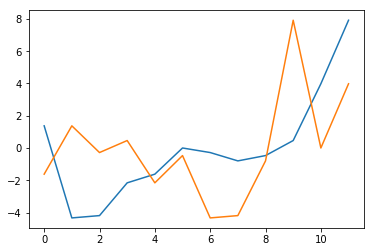

In [322]:
plt.plot(xaxis, tmp['layer_val'])
plt.plot(xaxis, test)

In [332]:
nrPermutations = 1000

permutations = np.zeros((nrPermutations,len(tmp)))

for n in range(nrPermutations):
    permutations[n] = np.random.permutation(tmp['layer_val'].array)    

In [333]:
permutations

array([[-0.27157563, -2.14529643,  7.91253693, ...,  0.4712436 ,
        -0.78731878, -4.3149518 ],
       [ 3.9825852 , -0.27157563,  0.4712436 , ..., -4.17158285,
         7.91253693, -1.60849684],
       [ 1.3809018 , -2.14529643, -0.45863779, ..., -4.17158285,
         0.01059259, -1.60849684],
       ...,
       [ 1.3809018 , -2.14529643, -0.78731878, ..., -0.27157563,
        -4.3149518 , -4.17158285],
       [-2.14529643, -0.27157563,  0.01059259, ..., -4.3149518 ,
        -0.45863779, -4.17158285],
       [-4.17158285, -0.45863779,  0.01059259, ...,  1.3809018 ,
        -1.60849684,  0.4712436 ]])

In [334]:
avg = np.average(permutations, axis=0)

In [340]:
stdErr = np.std(permutations, axis=0)

In [347]:
tmp

,subject,seed_roi,read_roi,layer,layer_val,depth


In [350]:
digits

['D2', 'D3', 'D4']

In [348]:
readRoi

'D3'

In [358]:
permutSub_list=[]
permutSeed_rois=[]
permutRead_rois=[]
permutLayer_val=[]
permutLayerNr=[]
permutSeedDepths_list=[]
permutCount = []

In [373]:
for sub in subs:
    
    for seedDigit in digits:
    
        nonseeds = digits.copy()
        nonseeds.remove(seedDigit)

        for readRoi in nonseeds:
            
            for seedLayer in ['01','02','03']:

                tmp = sub_data.loc[(sub_data['read_roi']==readRoi)&(sub_data['seed_roi']==seedDigit)&(sub_data['depth']==seedLayer)&(sub_data['subject']==sub)]


                for i in range(nrPermutations):
                    permutation = np.random.permutation(tmp['layer_val'].array)    

                    for n, val in enumerate(permutation):                
                        permutLayer_val.append(float(np.copy(val)))
                        permutLayerNr.append(n+1)
                        permutSeed_rois.append(str(seedDigit))
                        permutRead_rois.append(str(readROI))
                        permutSub_list.append(sub)
                        permutSeedDepths_list.append("%02d" % (int(seedLayer),))
                        permutCount.append(i+1)

                    
permutSub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth', 'permutCount'])
permutSub_data['subject']=permutSub_list
permutSub_data['seed_roi']=permutSeed_rois
permutSub_data['read_roi']=permutRead_rois
permutSub_data['layer']=permutLayerNr
permutSub_data['layer_val']=permutLayer_val
permutSub_data['depth']=permutSeedDepths_list
permutSub_data['permutCount']=permutCount

In [368]:
permutSub_data

,subject,seed_roi,read_roi,layer,layer_val,depth,permutCount
0,sub-02,D2,D3,1,-5.525634,01,1
1,sub-02,D2,D3,2,0.220200,01,1
2,sub-02,D2,D3,3,-1.400569,01,1
3,sub-02,D2,D3,4,-0.203929,01,1
4,sub-02,D2,D3,5,-3.391660,01,1
5,sub-02,D2,D3,6,0.950204,01,1
6,sub-02,D2,D3,7,0.550274,01,1
7,sub-02,D2,D3,8,2.370354,01,1
8,sub-02,D2,D3,9,0.117919,01,1
9,sub-02,D2,D3,10,12.859507,01,1


([], <a list of 0 Text xticklabel objects>)

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



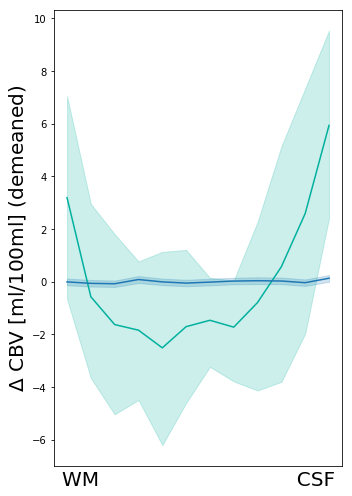

In [365]:
fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))


sns.lineplot(ax=ax, data = sub02Data, x='layer', y='layer_val',color=color)


sns.lineplot(ax=ax, data = permutSub_data.loc[(permutSub_data['depth']=='01')&(permutSub_data['subject']=='sub-02')], x='layer', y='layer_val')


ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

plt.xlabel("WM                               CSF",fontsize=20)

plt.xticks([],[])

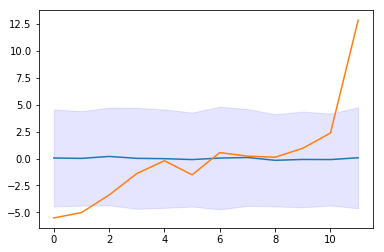

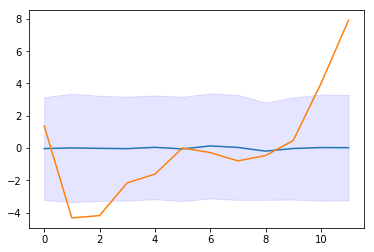

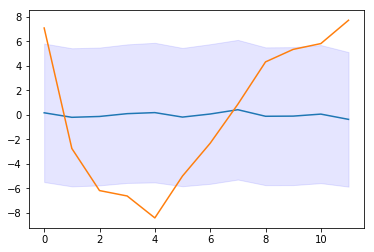

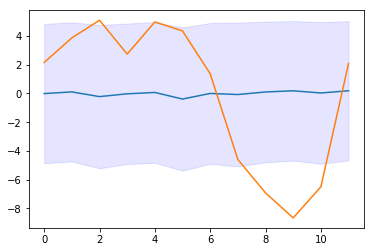

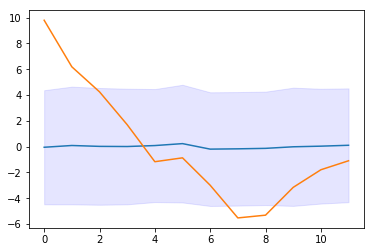

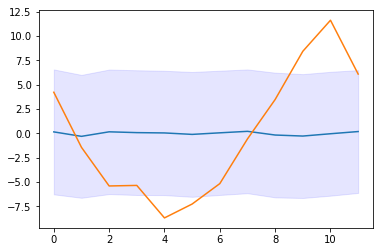

In [352]:
for seedDigit in digits:
    
    nonseeds = digits.copy()
    nonseeds.remove(seedDigit)
    
    for readRoi in nonseeds:
        
        tmp = sub02Data.loc[(sub_data['seed_roi']==seedDigit)&(sub_data['read_roi']==readRoi)]
        
        permutations = np.zeros((nrPermutations,len(tmp)))

        for n in range(nrPermutations):
            permutations[n] = np.random.permutation(tmp['layer_val'].array)    


        avg, stdErr = np.average(permutations, axis=0), np.std(permutations, axis=0)
        
        fig, ax = plt.subplots()

        plt.plot(xaxis, avg)
        plt.plot(xaxis, tmp['layer_val'])


        ax.fill_between(xaxis, (avg-stdErr), (avg+stdErr), color='b', alpha=.1)

### For BOLD

In [194]:
sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]

for sub in ['sub-02']:
    
    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)
    
    
    for pe in range(1,10):
        seedDigit = mappingDict[str(pe)]['digit']
        seedLayer = mappingDict[str(pe)]['seedLayer']
        print(f'Seed: {seedDigit} layer {seedLayer}')
        
        nonseeds = digits.copy()
        nonseeds.remove(seedDigit)
        
        resultsMap = nb.load(f'{root}/derivatives/{sub}/func/{sub}_ses-003_task-restBA3b_run-001_BOLD.feat/stats/pe{pe}.nii.gz').get_fdata()
        
        for readROI in nonseeds:
            print(f'read from: {readROI}')
                
            roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{readROI}_12_layers_equivol.nii').get_fdata()[box[0], box[1], box[2]]
        
            profile = []

            for layer in np.unique(roi)[1:]:

                layerRoi = roi == layer

                mask_mean = np.mean(resultsMap[layerRoi])
                profile.append(mask_mean)

            arr = np.array(profile)
            arr = arr-np.mean(arr)

            for n, val in enumerate(arr):                
                layer_val.append(float(np.copy(val)))
                layerNr.append(n+1)
                seed_rois.append(str(seedDigit))
                read_rois.append(str(readROI))
                sub_list.append(sub)
                seedDepths_list.append("%02d" % (int(seedLayer),))

Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3


/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



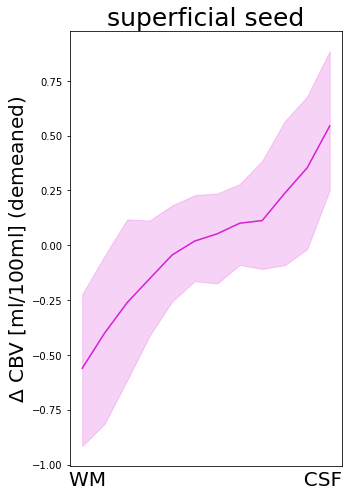

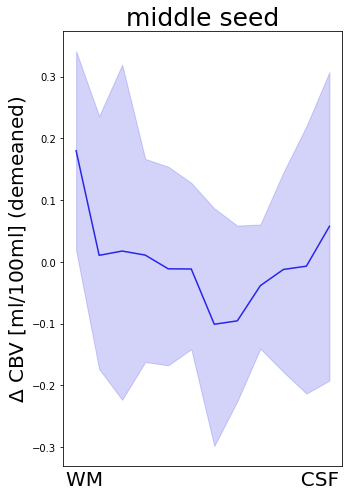

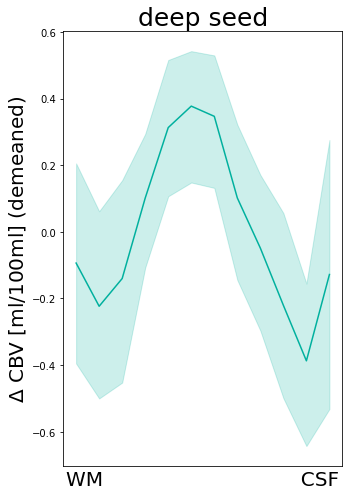

In [195]:
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list



colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['01','02','03']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']


for depth,seed_label,color in zip(depths,seed_labels,colors):
    fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))
    
    plt.title('%s seed'%(seed_label), fontsize=25)


    sns.lineplot(ax=ax, data = sub_data.loc[(sub_data['depth']==depth)&(sub_data['subject']=='sub-02')], x='layer', y='layer_val',color=color)
    ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

    plt.xlabel("WM                               CSF",fontsize=20)

    plt.xticks([],[])

In [858]:
fslmap = nb.load('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-15/D2Layer1seed+.feat/stats/tstat1.nii.gz').get_fdata()
meanFunc = nb.load('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-15/D2Layer1seed+.feat/mean_func.nii.gz').get_fdata()

beta = np.multiply(fslmap, meanFunc)

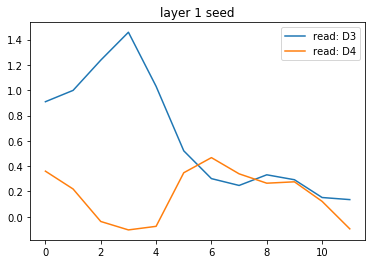

In [859]:
profile = []

for readROI in digits[1:]:
    roi = nb.load(f'{root}/derivatives/sub-15/anat/sub-15_{readROI}_12_layers_equivol.nii').get_fdata()[x_idx_range, y_idx_range, z_idx_range]
    profile = []
    for layer in np.unique(roi)[1:]:

        layerRoi = roi == layer

        mask_mean = np.mean(fslmap[layerRoi])
        profile.append(mask_mean)
    plt.plot(profile, label=f'read: {readROI}')
    

plt.title(f'layer 1 seed')
plt.legend()